# Non Linear Metric Learning
### Authors: Christian Ingwersen, Harald Løvenskjold Mortensen & Thomas Ørkild
 This notebook is for running training the $\chi^2$-LMNN on the Amazon, Traffic Signs and Cats & Dogs dataset

In [136]:
from datagenerator import DataGen
import numpy as np
import tensorflow as tf
import scipy as sc
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tqdm
%matplotlib inline

from IPython import display

tf.enable_eager_execution()

## Distance functions

In [137]:
def single_chi_sq_dist(x, y):
    return 0.5 * np.sum((x-y)**2 / (x+y+1e-20))

def chi_sq_dist(X):
    X_1 = tf.expand_dims(X, 1)
    X_2 = tf.expand_dims(X, 0)

    epsilon = tf.constant(0.000001)
    
    return 0.5 * tf.reduce_sum(tf.squared_difference(X_1, X_2) / (X_1+X_2 + epsilon), 2)

def chi_sq_nn(X):
    with tf.device("/cpu:0"):
        dist = chi_sq_dist(X)
        return np.argsort(np.abs(dist),axis=1)

def euclidean_nn(X):
    dist = distance_matrix(X,X)
    return np.argsort(dist,axis=1)

## Dataset 1 - Amazon

In [126]:
#a = np.load("amazon_data.npz")
a = np.load("amazon_data.npz")
X =a["X"]
y = a["y"]

dims = X.shape[1]
K = 3

X = X / np.tile(np.sum(X, axis=1), (dims, 1)).T
num_classes = len(np.unique(y))

In [127]:
N=200
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = X_train[:N]
y_train = y_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]


## Dataset 2-3 Cat & Dogs and Traffic Signs

In [154]:
#data =np.load("./surf_histograms_800.npz") # Traffic Signs
data =np.load("./cat_surf_histograms_800.npz") # Cats and Dogs
X_train = data['X_train'][:200]
y_train = data['y_train'][:200]=="cat"#.astype(np.int32)## #
X_test = data['X_test'][:200]
y_test = data['y_test'][:200]=="cat"#.astype(np.int32)#

uniq, count = np.unique(y_train, return_counts=True)
for u, c in zip(uniq, count):
    if c < 5:
        X_train = X_train[y_train  != int(u)]
        y_train = y_train[y_train != int(u)]
        X_test = X_test[y_test != int(u)]
        y_test = y_test[y_test != int(u)]

N = len(X_train)
num_classes = len(np.unique(y_train))
dims = X_train.shape[1]

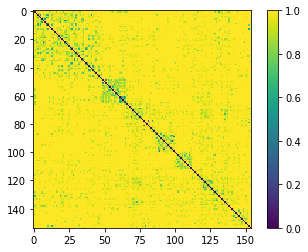

In [147]:
idx = np.argsort(y_train)

plt.imshow(pairwise_distances(X_train[idx,:], metric=single_chi_sq_dist))
plt.colorbar()

## Calculate target neighbours

In [67]:
nearest_points = chi_sq_nn(X_train.astype('float32'))
nn = np.zeros((N*K,2), dtype=np.int32)
for i in range(N):
    tmp = nearest_points[i]
    idx = [elem for elem in tmp if elem in np.where(y_train==y_train[i])[0]]
    nn[i::N,1] = idx[1:K+1]
    nn[i::N,0] = np.repeat(idx[0], K)

## Define helper functions

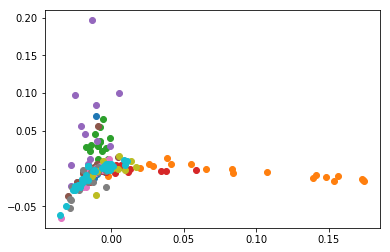

In [18]:
def plot_func(X,y):
    classes = np.unique(y)
    #plt.axis('equal')
    tmp = X.copy()
    tmp[:, 0] = X[:, 0] / X[:, 2]
    tmp[:, 1] = X[:, 1] / X[:, 2]
    
    for i in classes:
        plt.plot(tmp[y==i,0], tmp[y==i,1],'.')
    #plt.show()

t = 5
pca = PCA(2)
pca.fit(X_train)
trans_X_train = pca.transform(X_train)

for i in range(num_classes):
    plt.plot(trans_X_train[y_train==i,0], trans_X_train[y_train==i,1] , 'o')
#plt.plot(X[int(nn[t,0]),0],X[int(nn[t,0]),1],'x')
#plt.plot(X[nn[t,1:].astype(np.int),0],X[nn[t,1:].astype(np.int),1],'*')
#plt.plot(X[im[t,:].astype(np.int),0],X[im[t,:].astype(np.int),1],'*')
plt.show()


In [19]:
def get_impostors(D, nn, y, margin):
    N = np.shape(D)[0]
    idxs = tf.reshape(tf.tile(tf.range(N),[N*K]), (N*N*K,1))
    tn_idxs = tf.reshape(tf.tile(nn, [1, N]), (-1, 2))
    all_idxs = tf.concat([tn_idxs, idxs], axis=1)

    tn_index = all_idxs[:,:2]
    im_index = all_idxs[:,::2]
    tn_distance = tf.gather_nd(D, tn_index)
    im_distance = tf.gather_nd(D, im_index)
    
    is_too_close = im_distance <= margin + tn_distance
    is_different_class = tf.not_equal(tf.gather(y, tn_index[:,1]), tf.gather(y, im_index[:,1]))

    predicate = tf.logical_and(is_too_close, is_different_class)
    #print(tf.reduce_sum(tf.cast(predicate, tf.int32)))
    return tf.boolean_mask(all_idxs, predicate) # (idx, target neighbour index, imposter index)

def loss(X, A, nn, y, margin):
    L = tf.nn.softmax(A,axis=0)
    #X_bar = tf.cast(X @ L, tf.float32)
    X_bar = tf.cast(X @ tf.transpose(L), tf.float32)
    
    D = chi_sq_dist(X_bar)
    
    im_triple = get_impostors(D, nn, y, margin)
    #print(im_triple)
    
    pull_term = tf.gather_nd(D, nn) # (N*K, 1) where each element 
    pull_loss = tf.reduce_sum(pull_term)

    push_loss = tf.reduce_sum(margin + tf.gather_nd(D, im_triple[:,:2]) - tf.gather_nd(D, im_triple[:,::2]))
    #print(push_loss)
    loss = pull_loss + mu * push_loss
    return loss

def grad(X, A, nn, y, margin):
    with tf.GradientTape() as tape:
        loss_value = loss(X, A, nn, y, margin)
    return tape.gradient(loss_value, A)

## Training

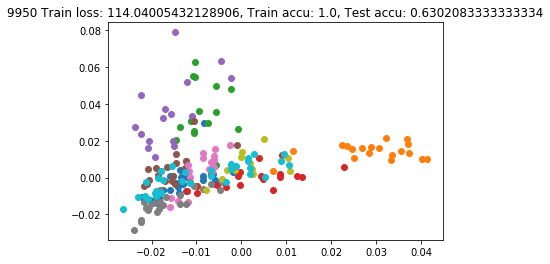

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [2:16:19<00:00,  1.31it/s]


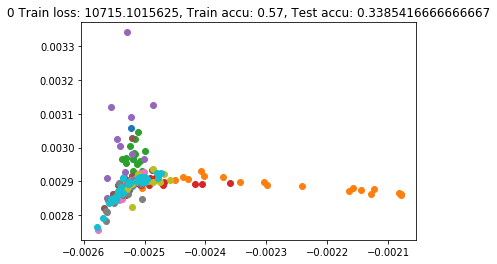

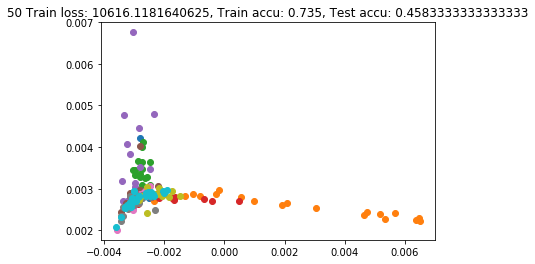

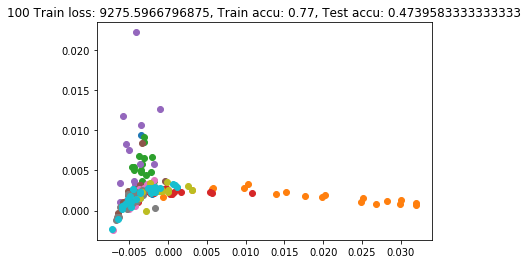

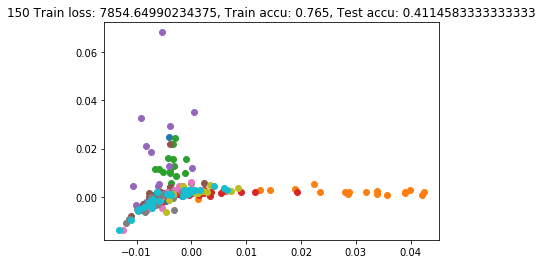

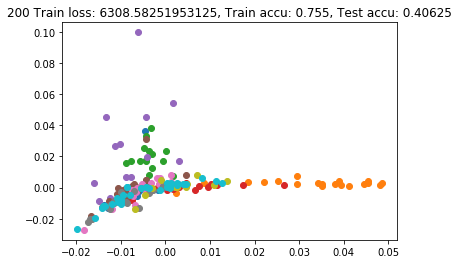

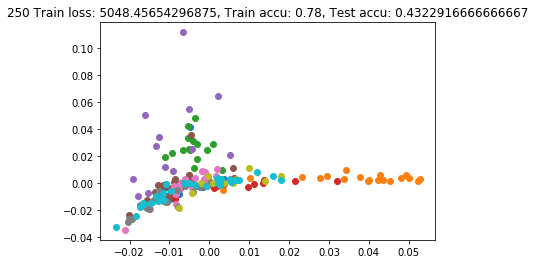

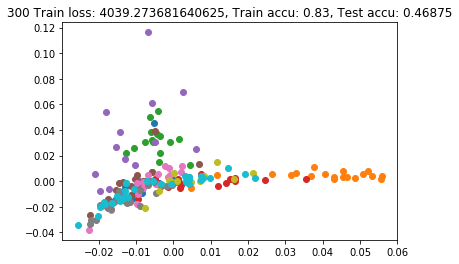

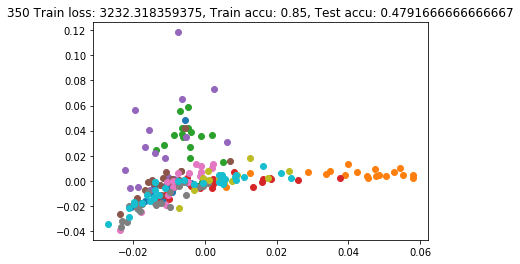

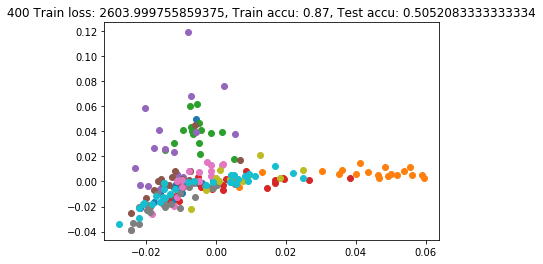

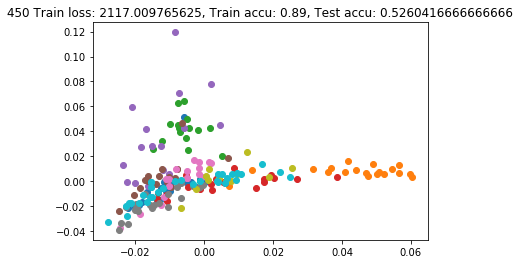

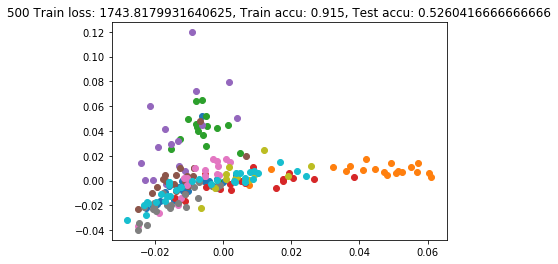

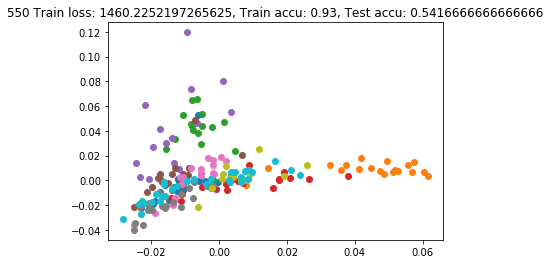

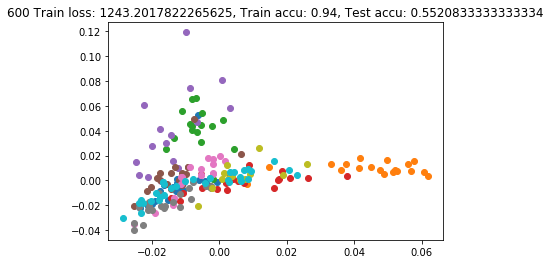

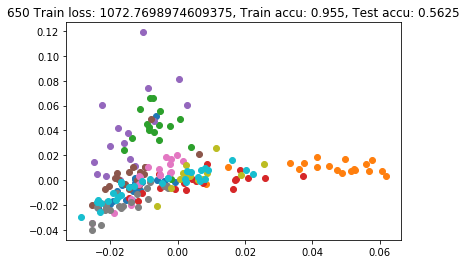

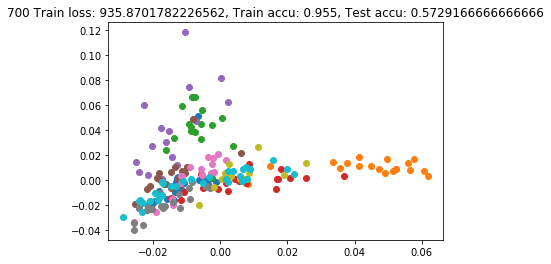

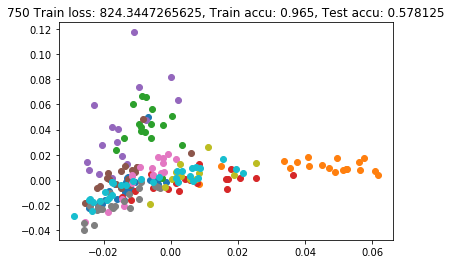

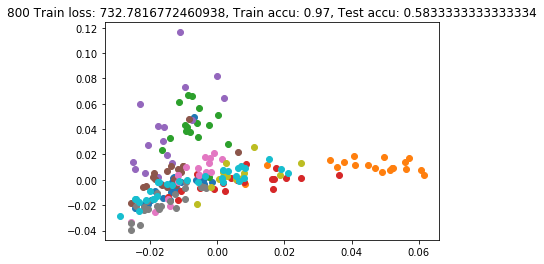

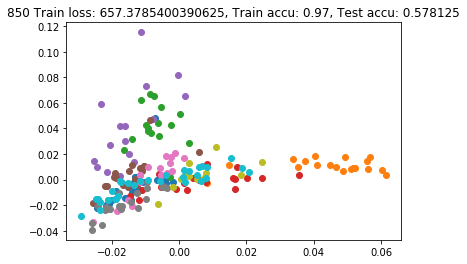

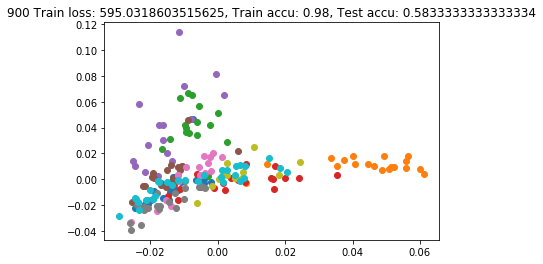

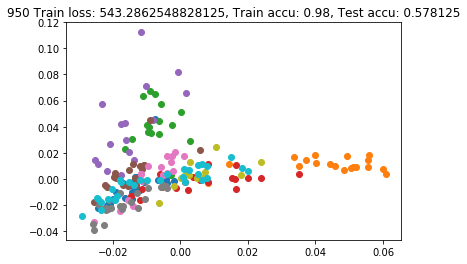

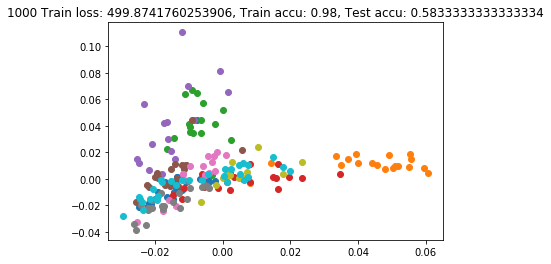

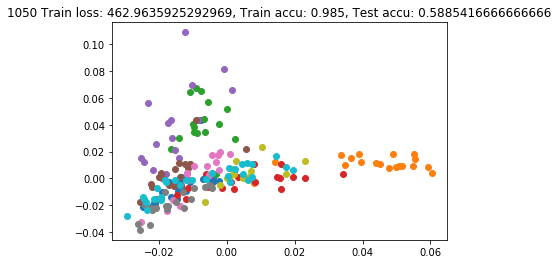

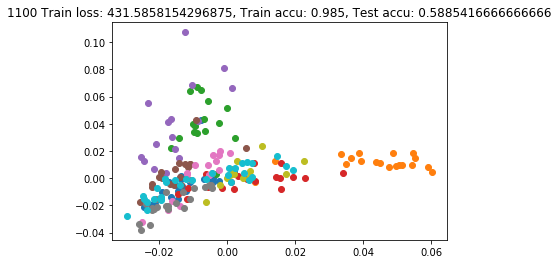

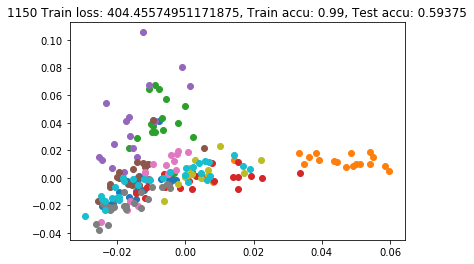

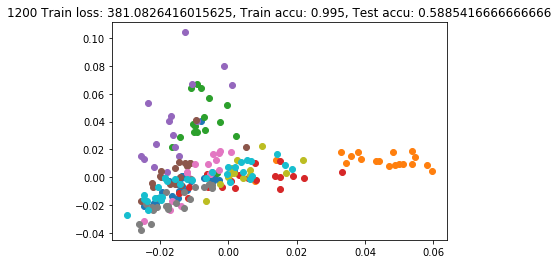

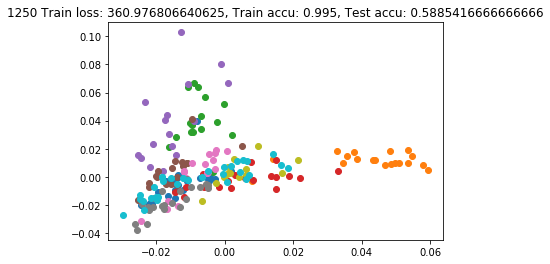

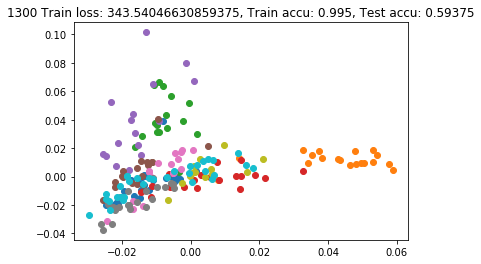

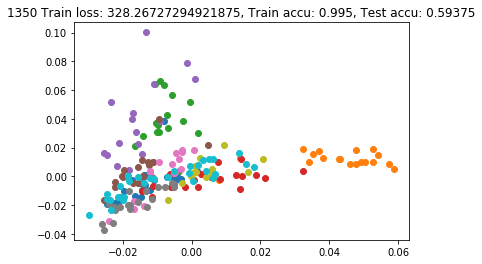

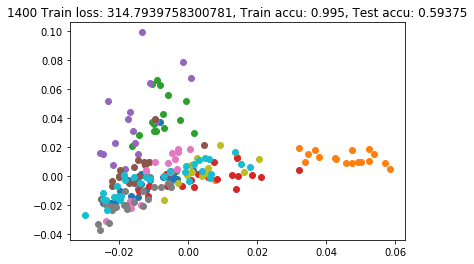

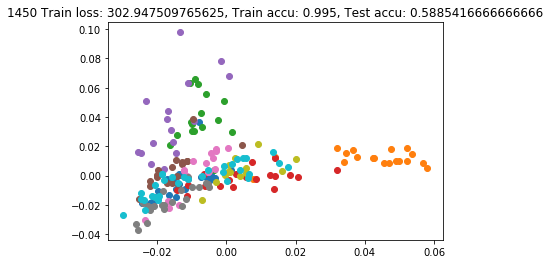

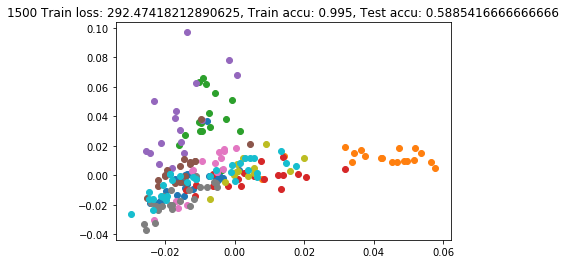

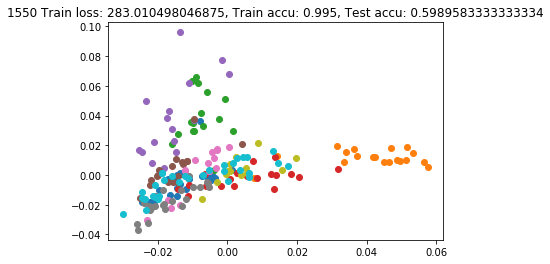

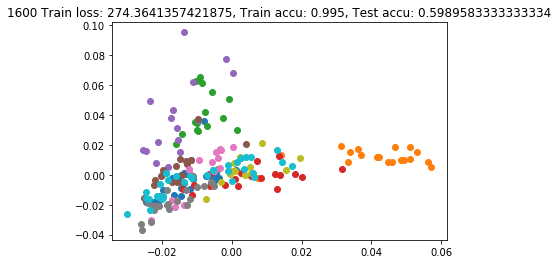

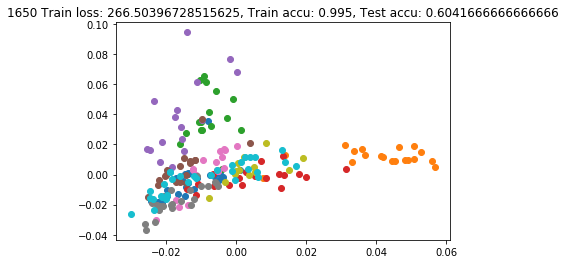

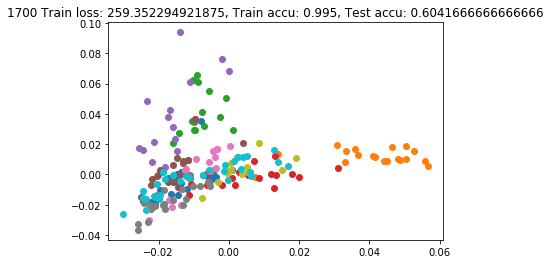

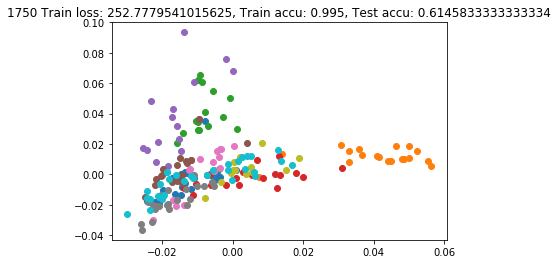

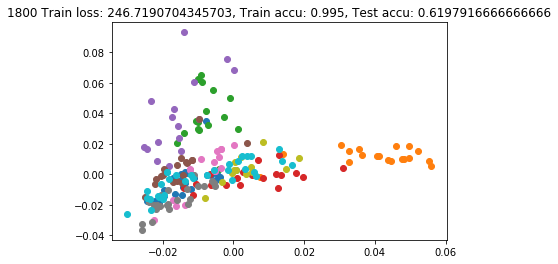

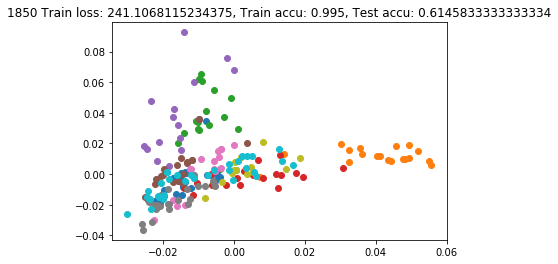

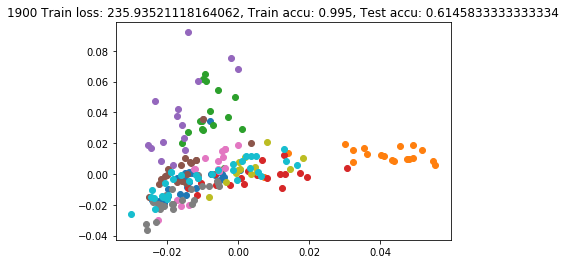

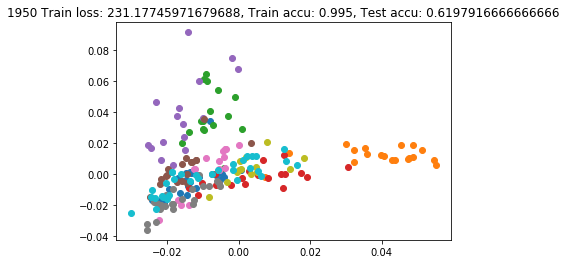

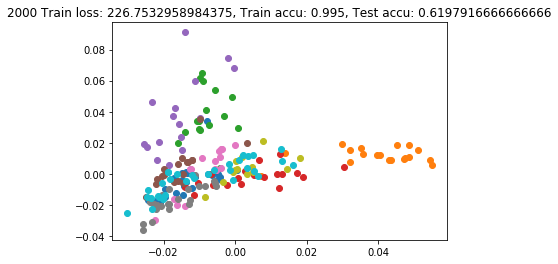

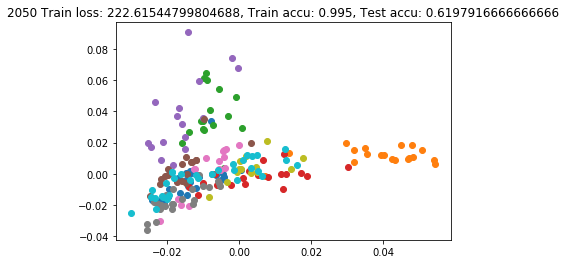

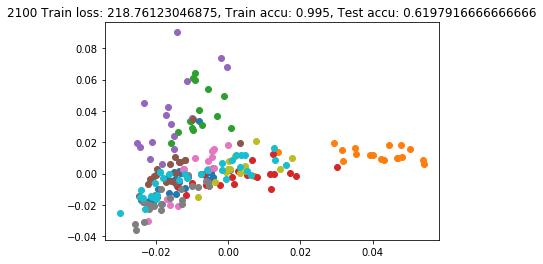

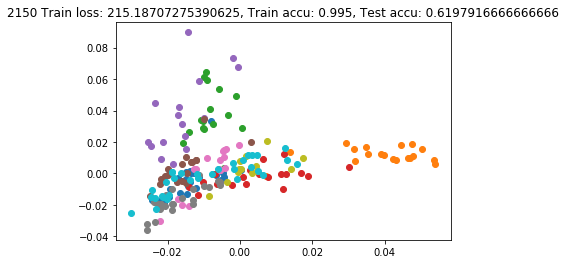

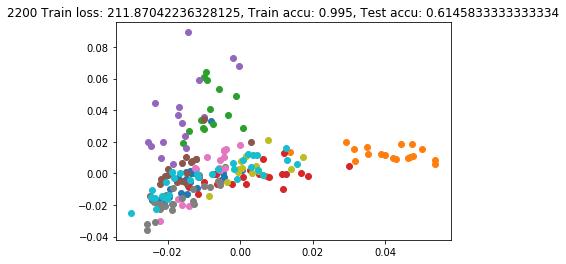

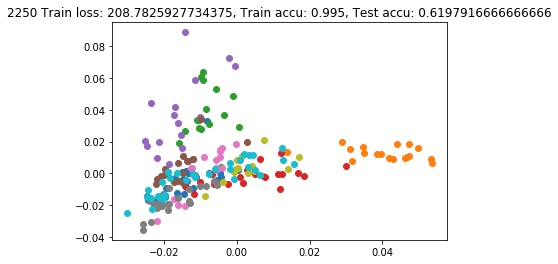

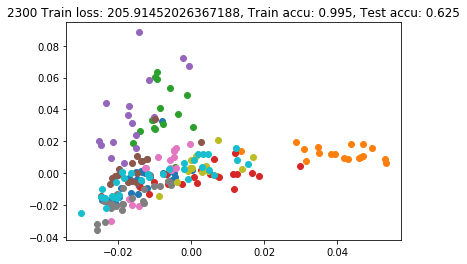

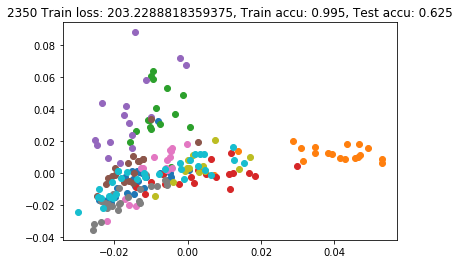

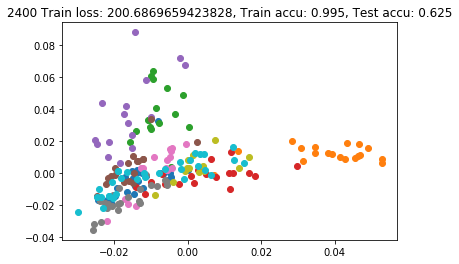

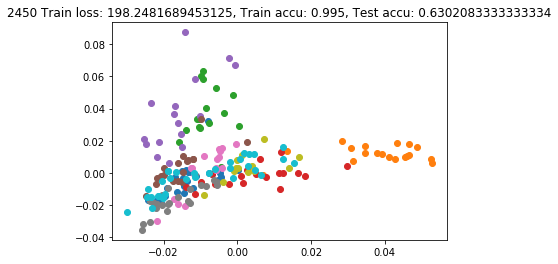

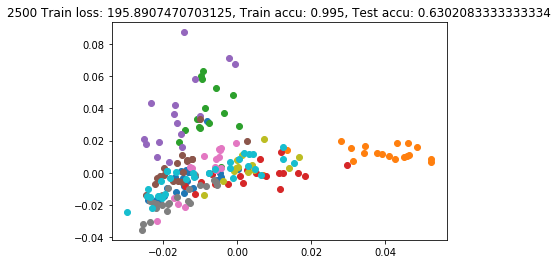

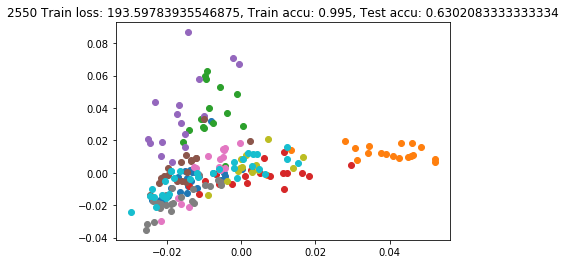

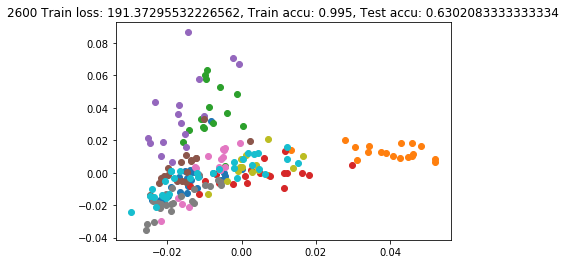

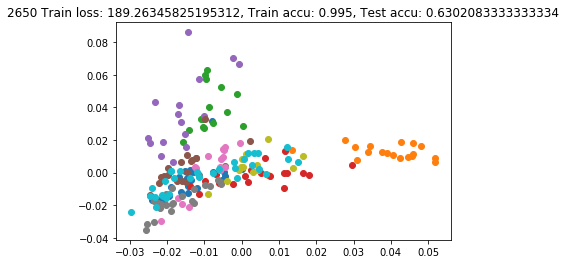

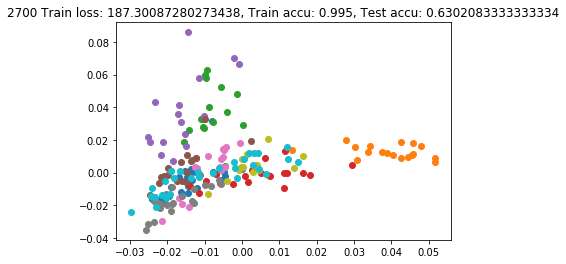

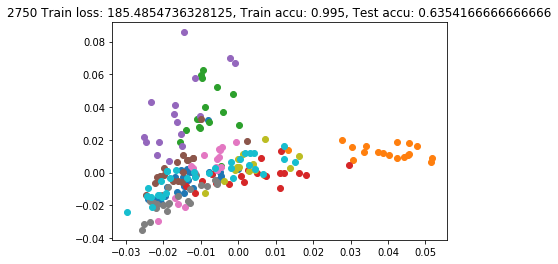

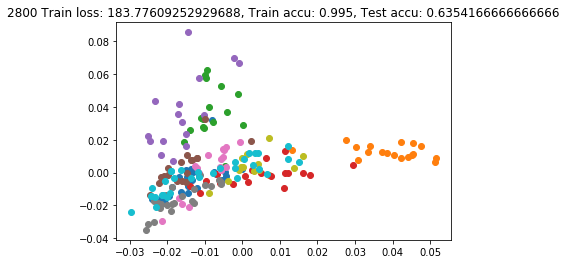

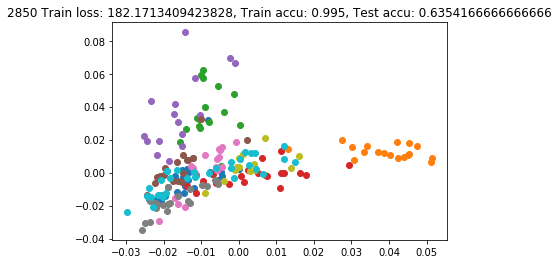

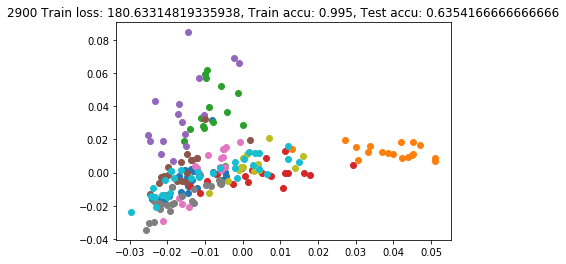

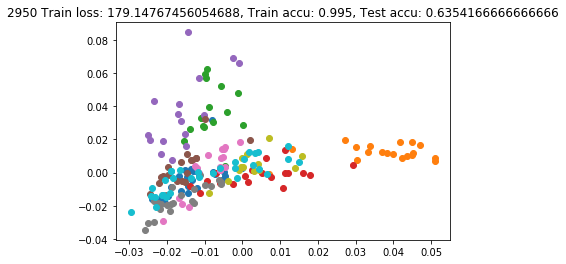

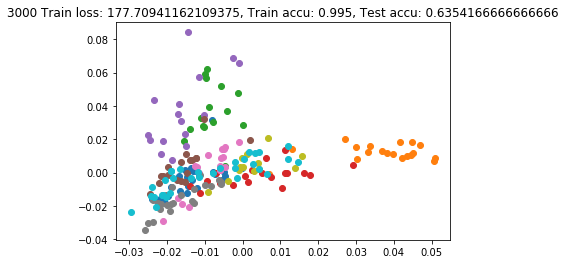

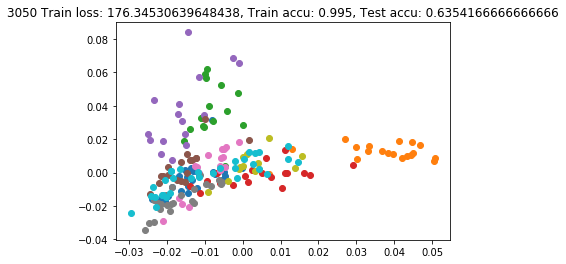

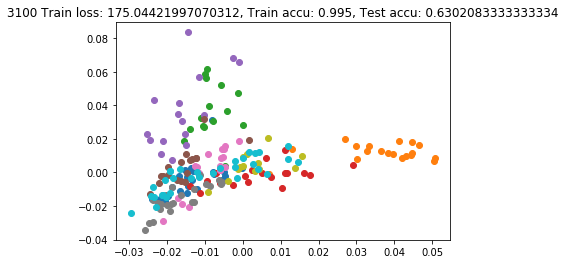

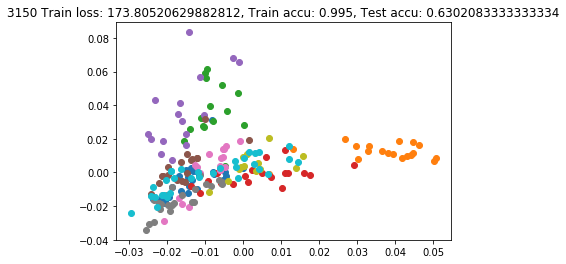

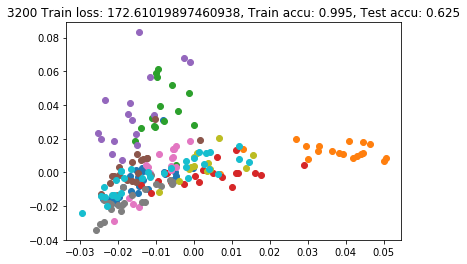

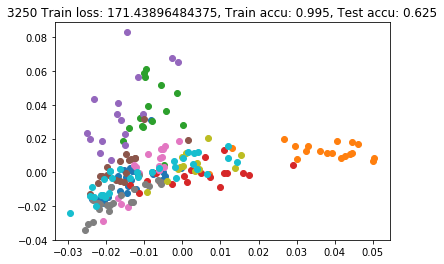

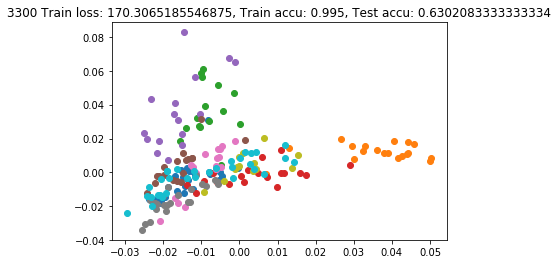

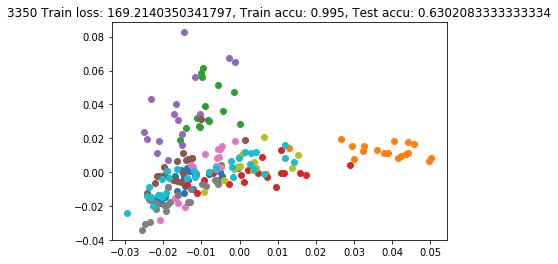

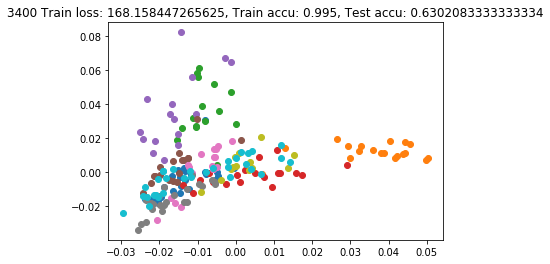

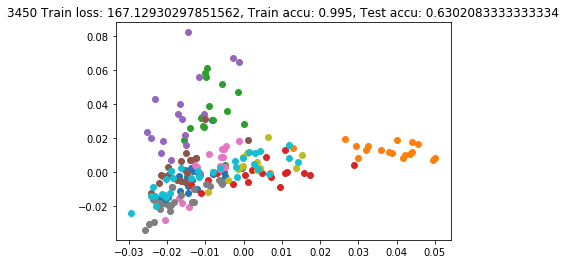

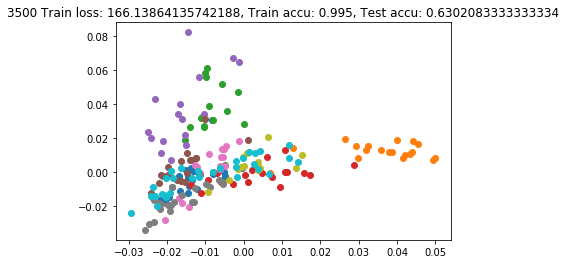

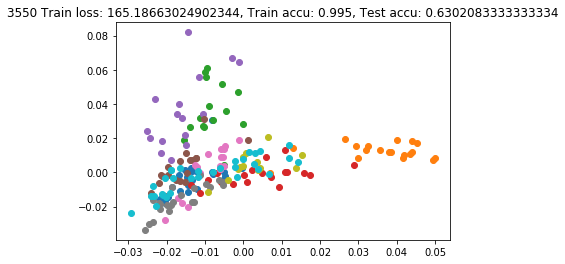

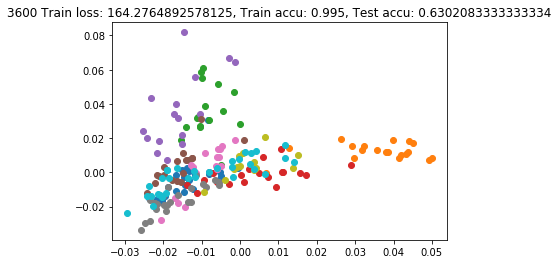

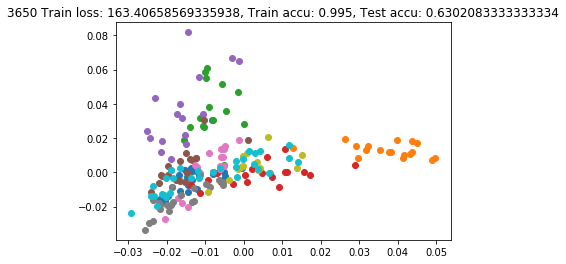

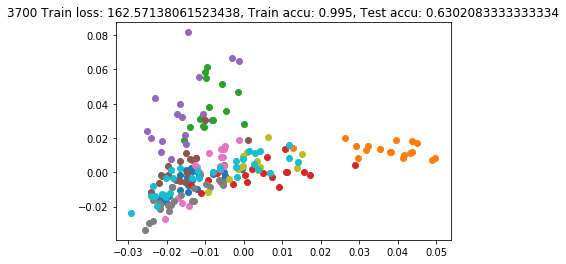

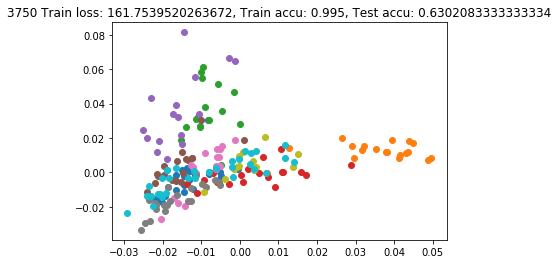

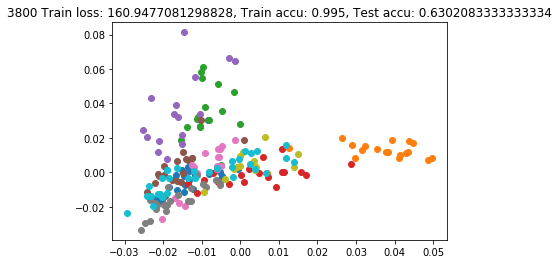

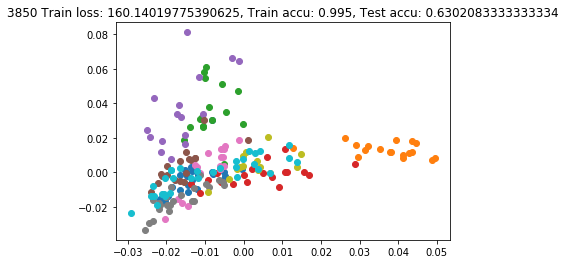

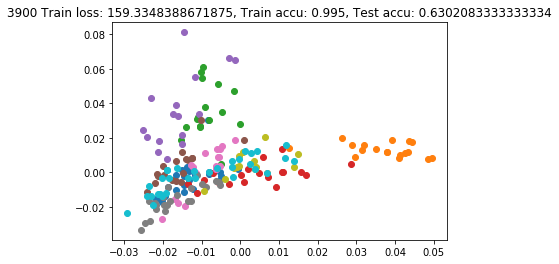

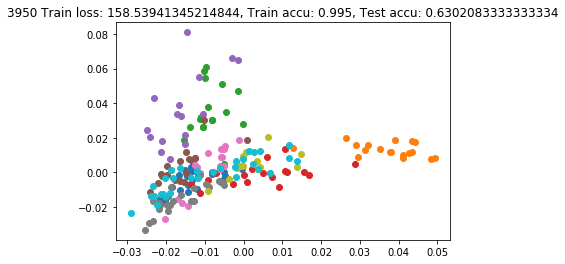

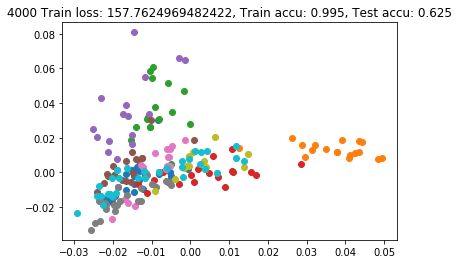

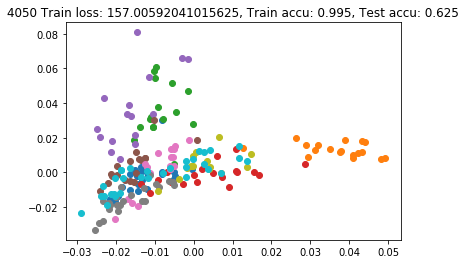

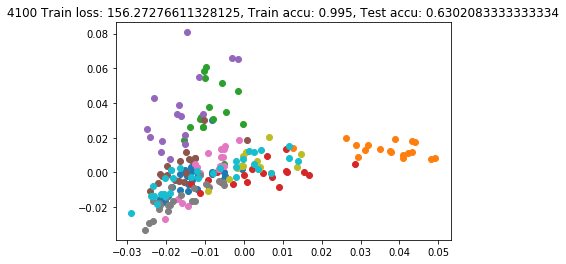

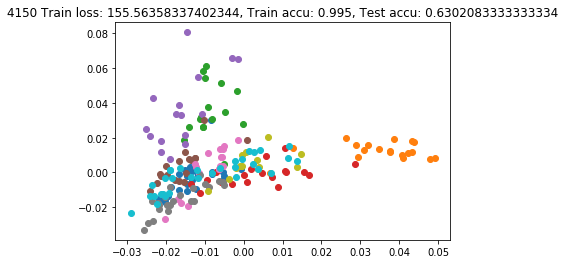

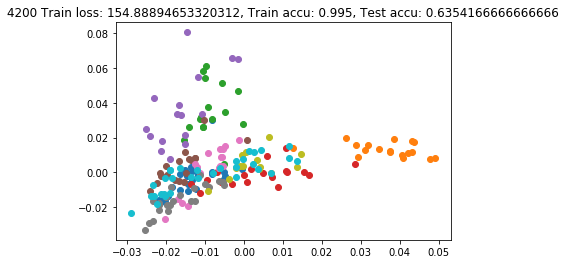

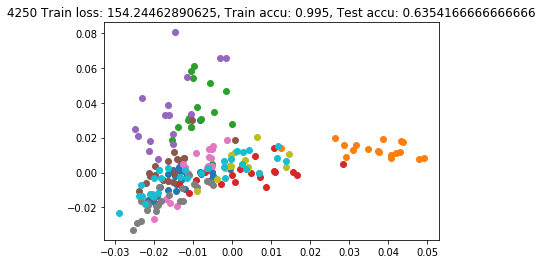

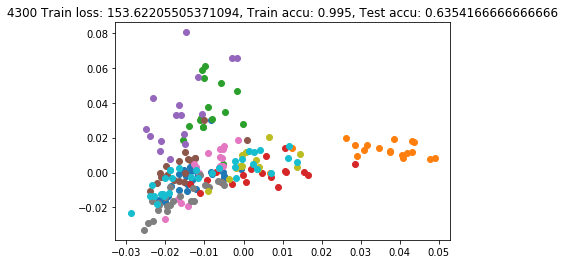

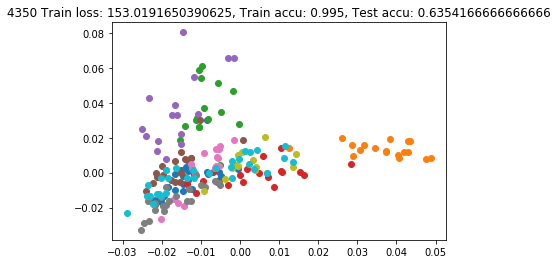

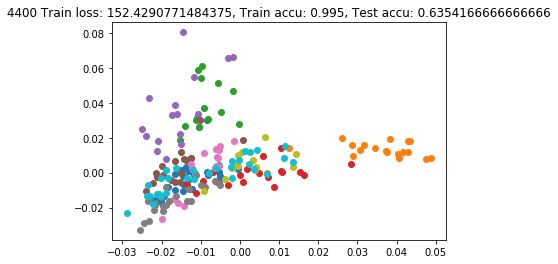

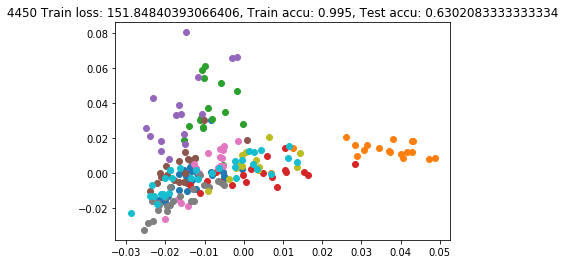

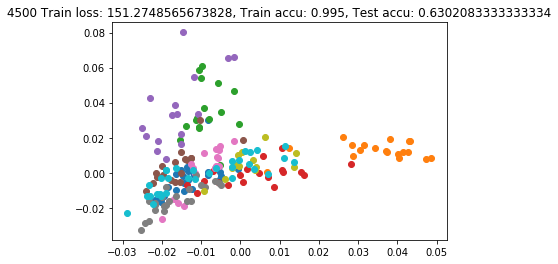

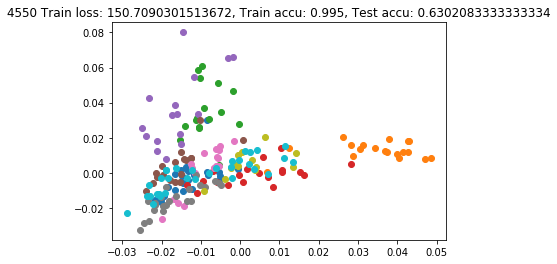

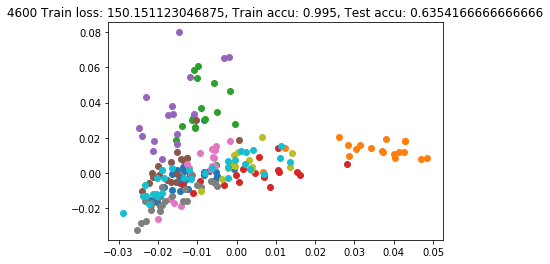

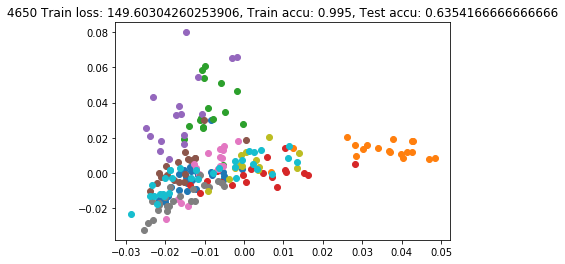

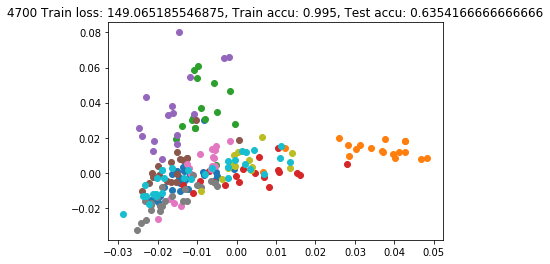

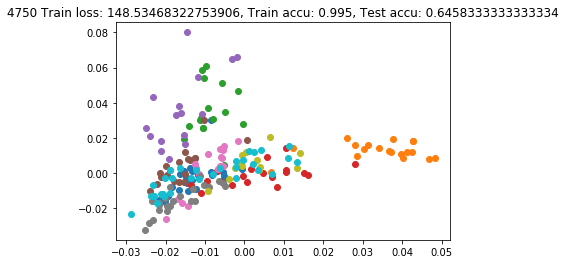

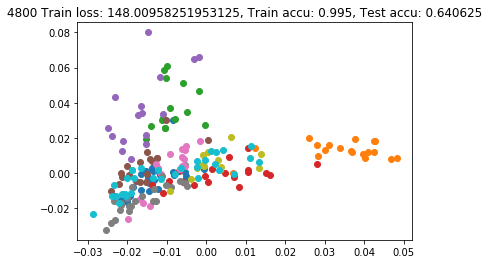

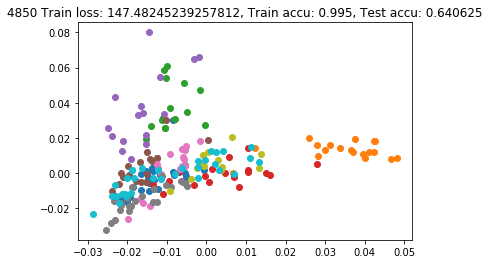

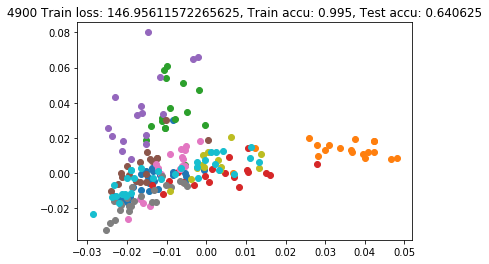

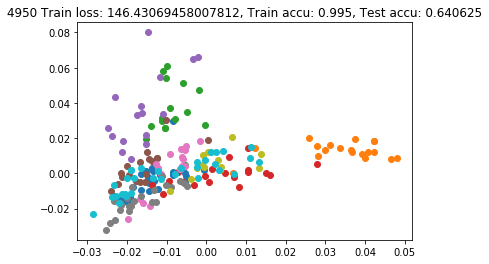

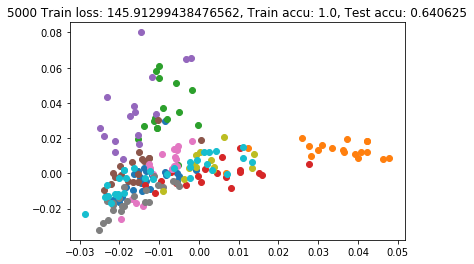

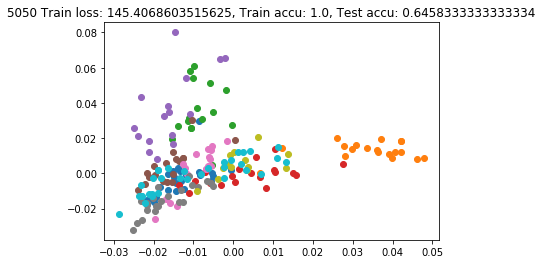

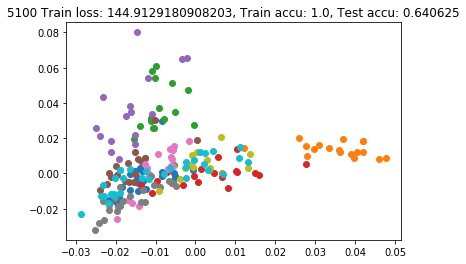

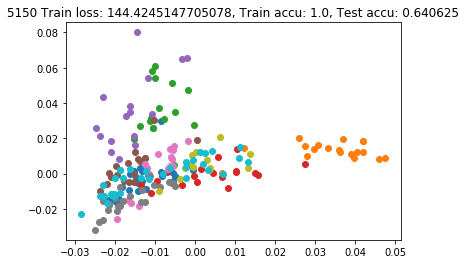

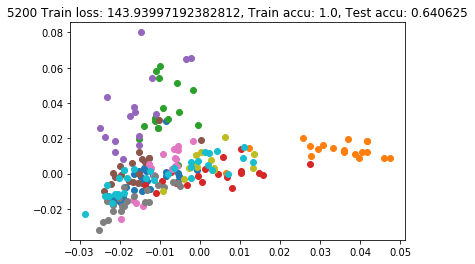

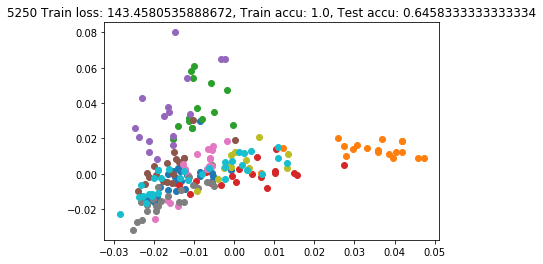

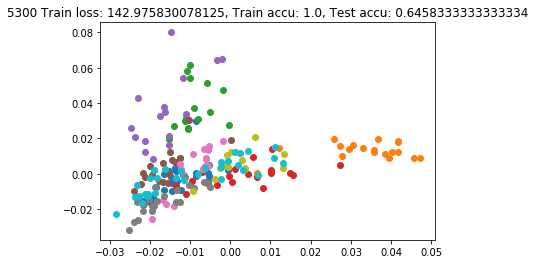

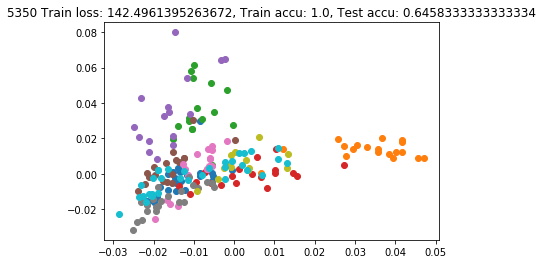

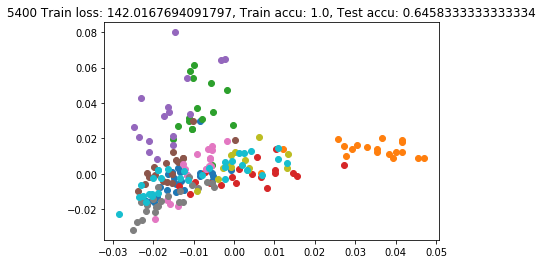

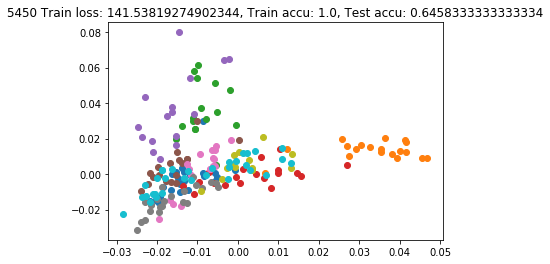

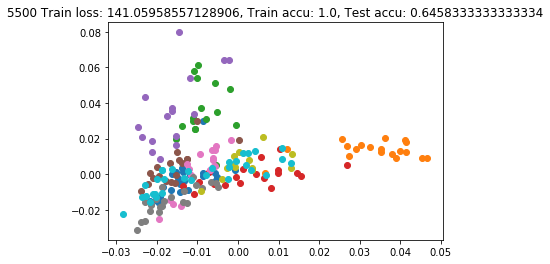

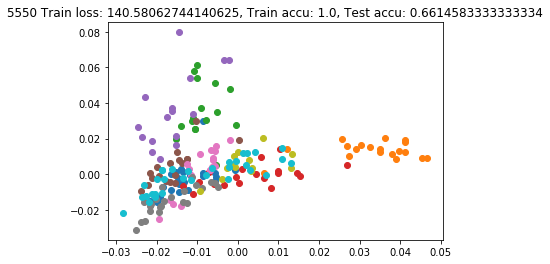

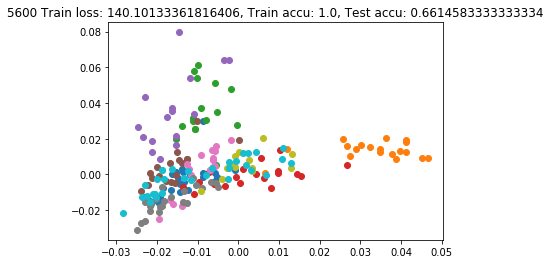

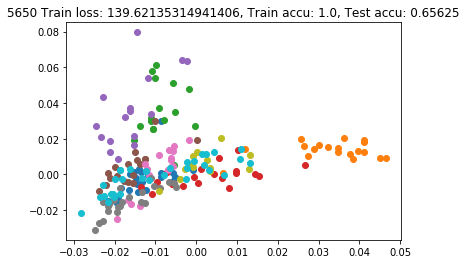

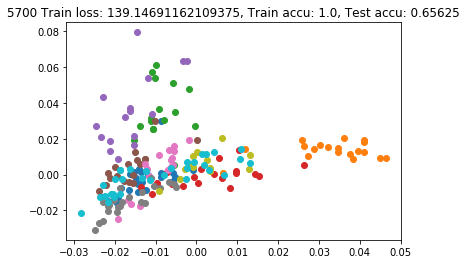

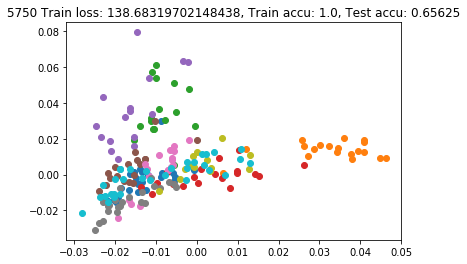

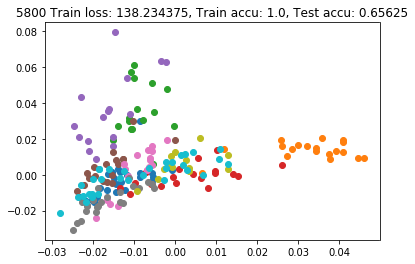

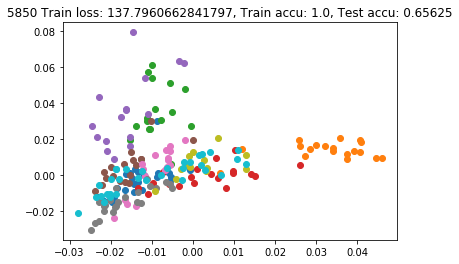

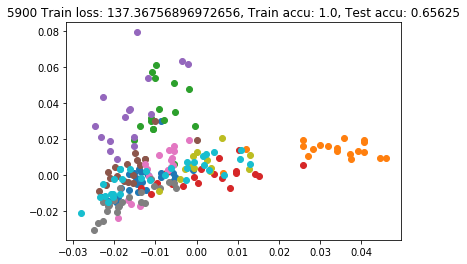

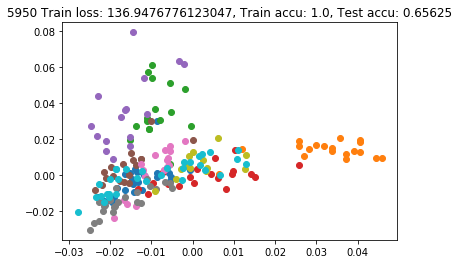

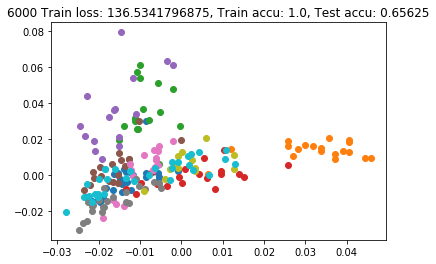

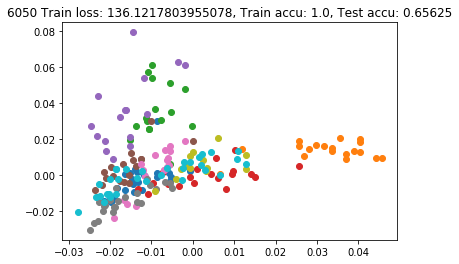

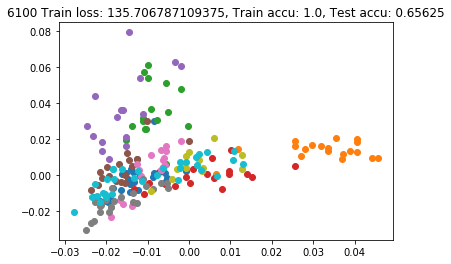

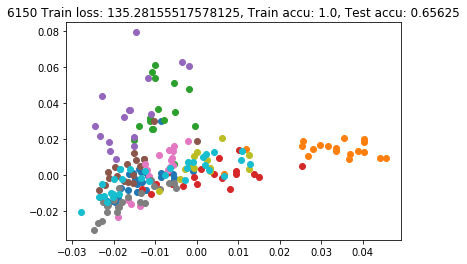

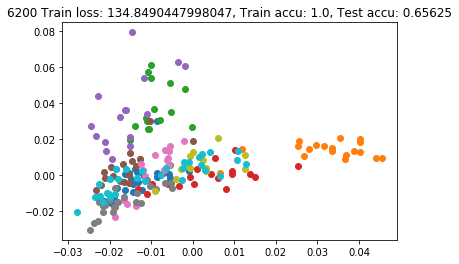

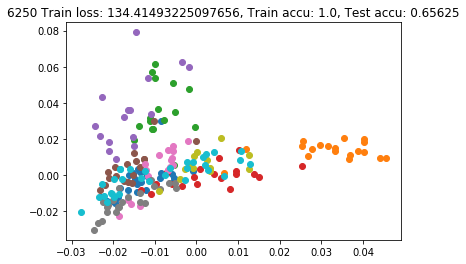

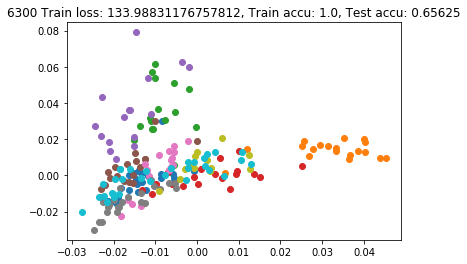

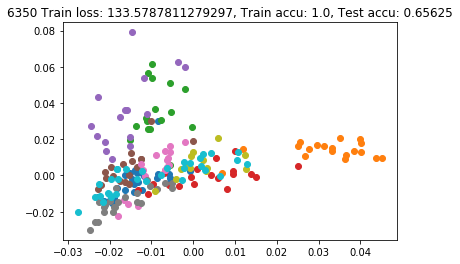

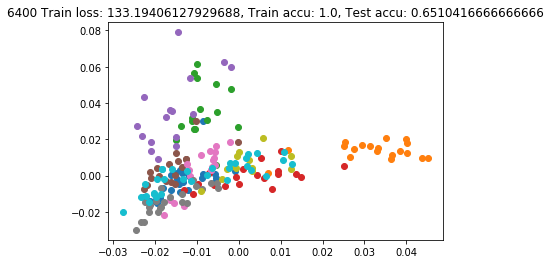

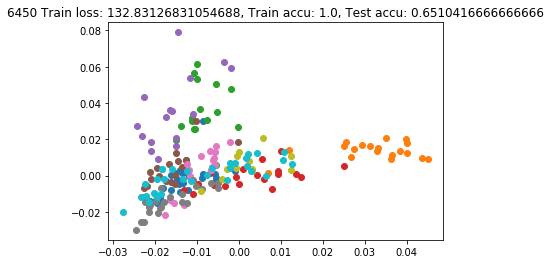

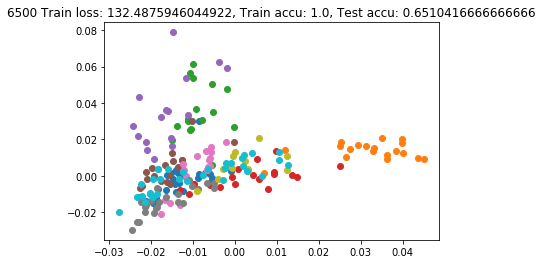

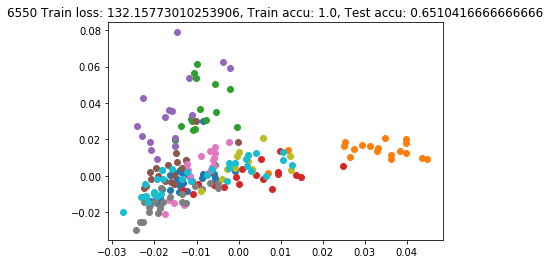

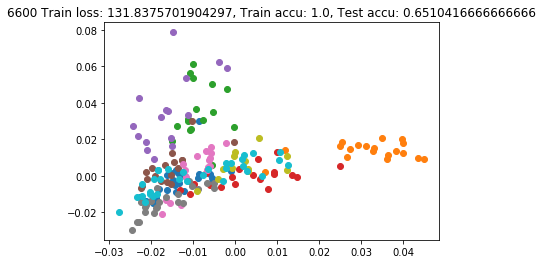

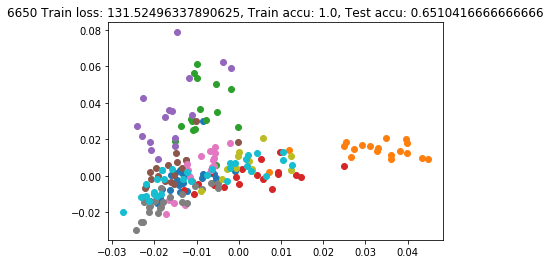

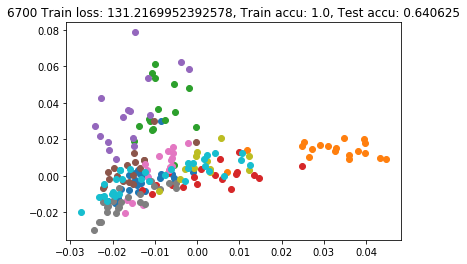

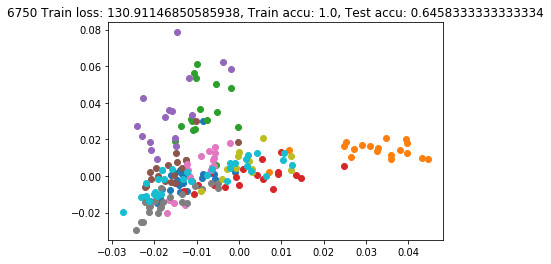

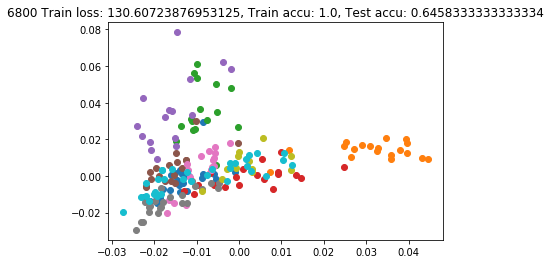

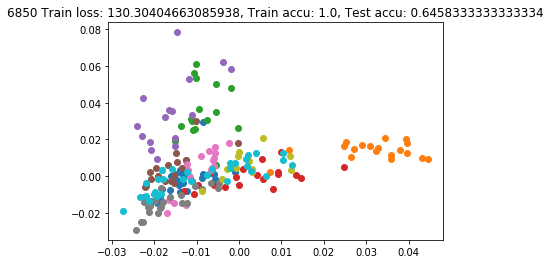

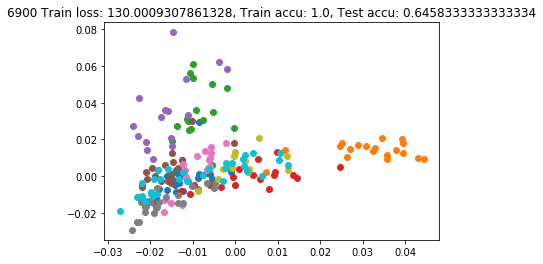

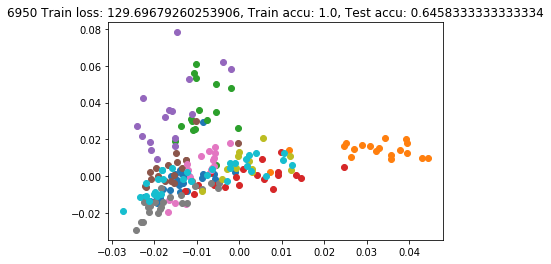

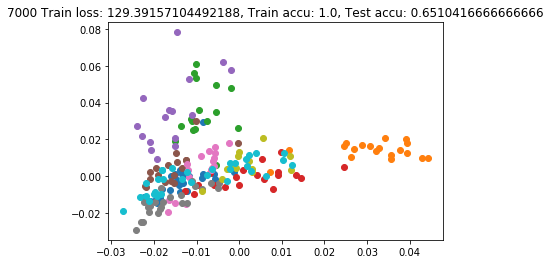

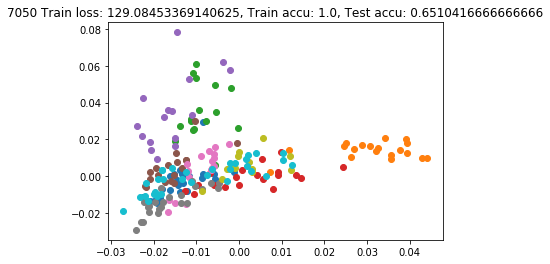

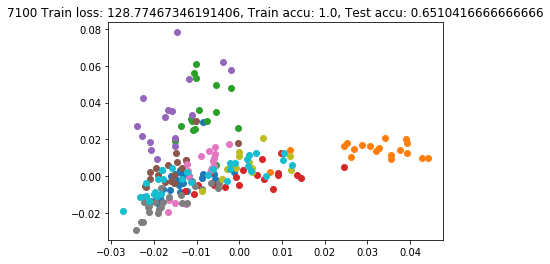

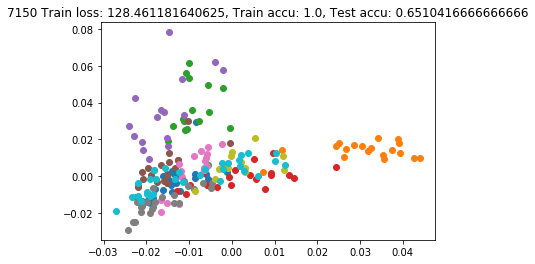

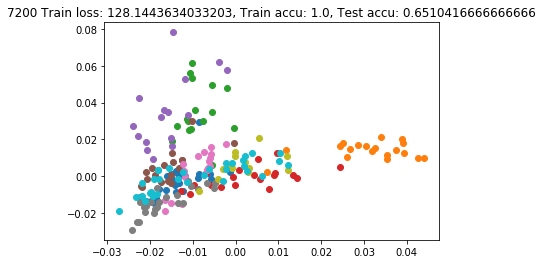

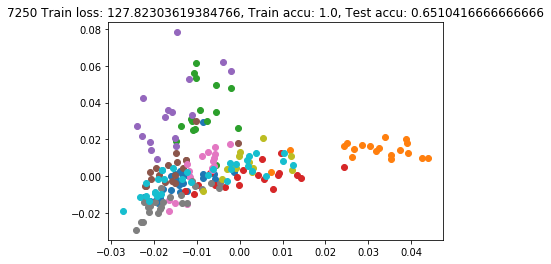

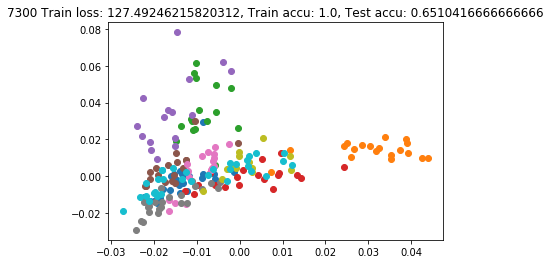

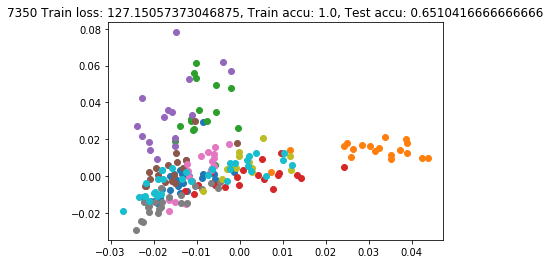

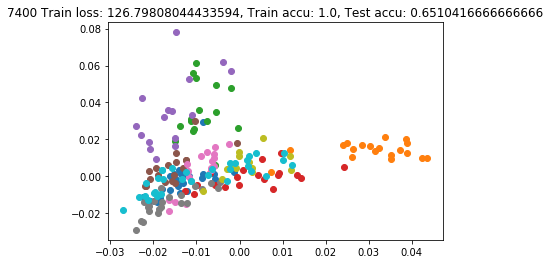

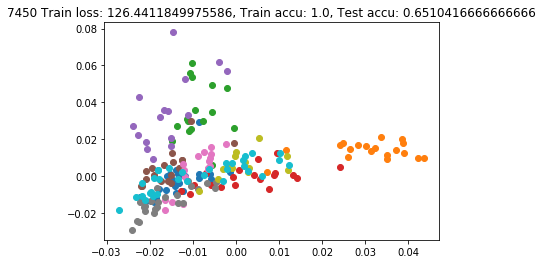

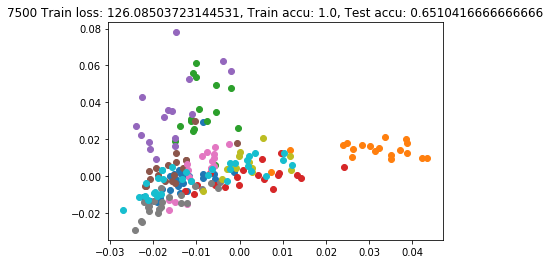

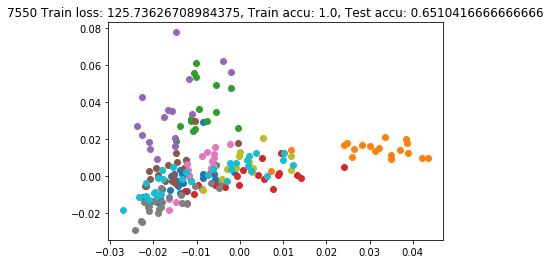

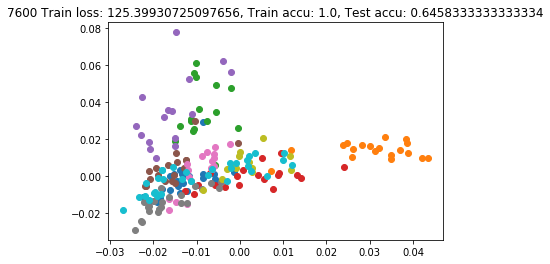

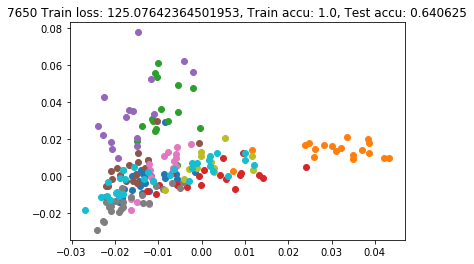

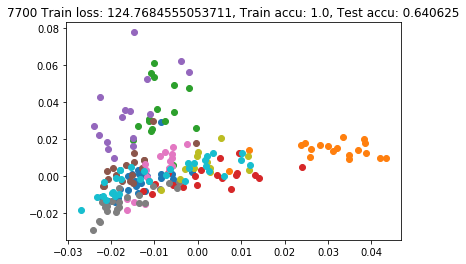

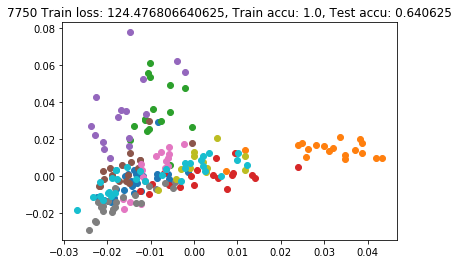

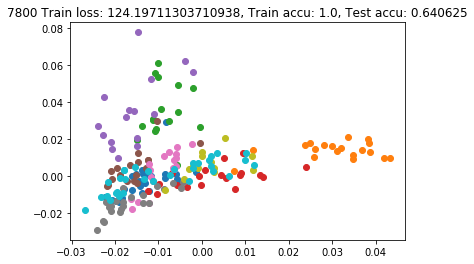

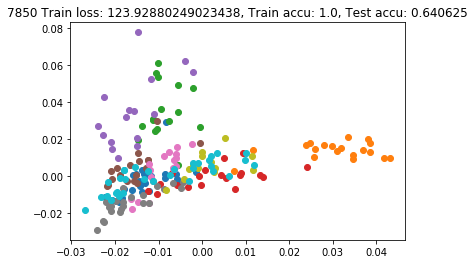

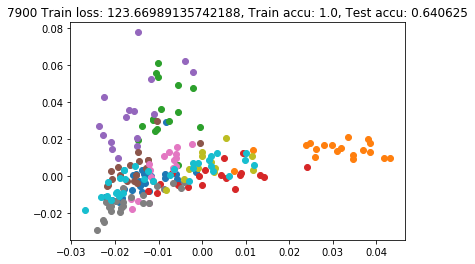

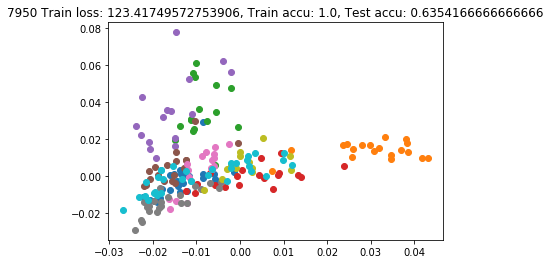

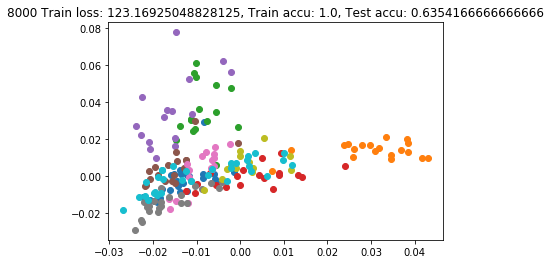

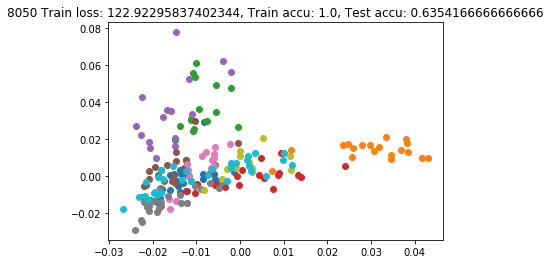

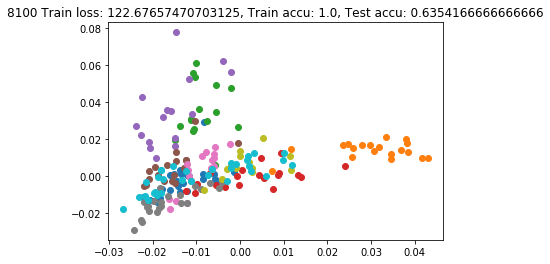

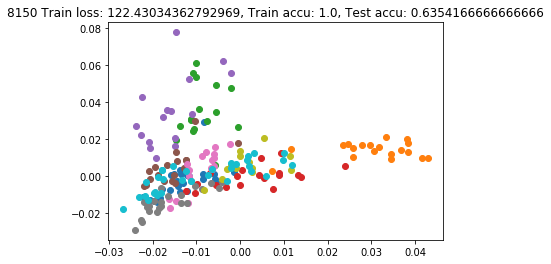

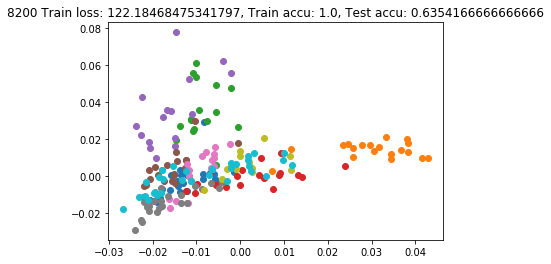

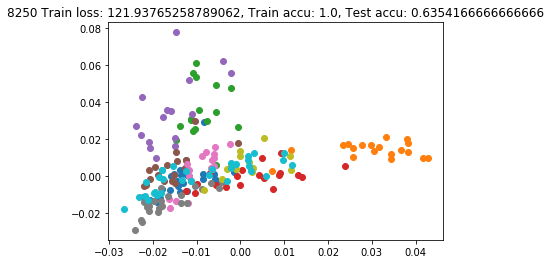

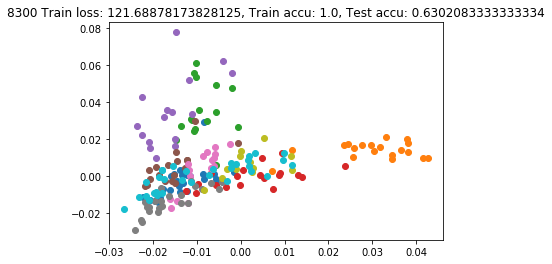

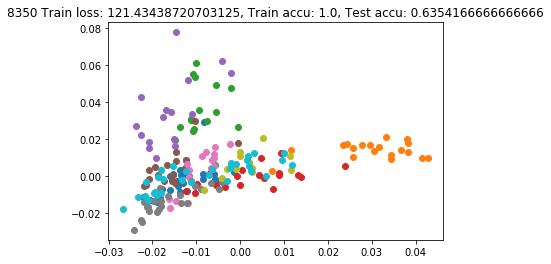

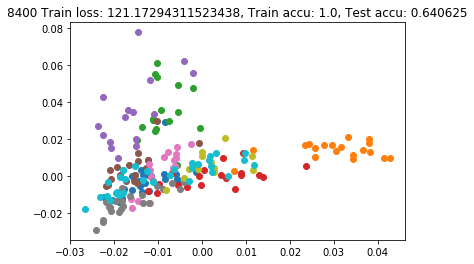

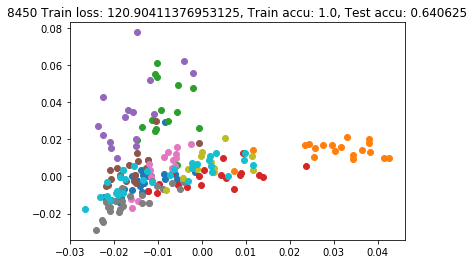

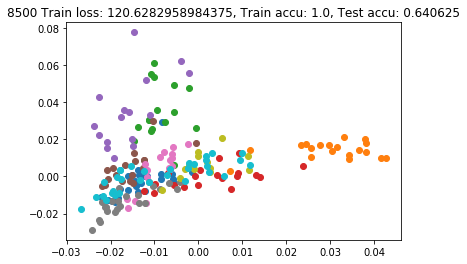

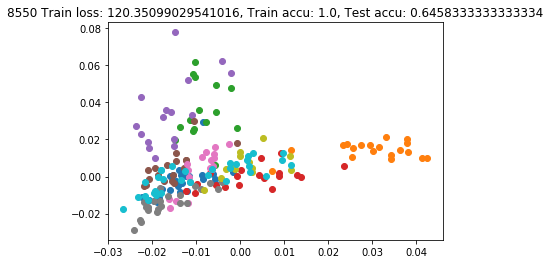

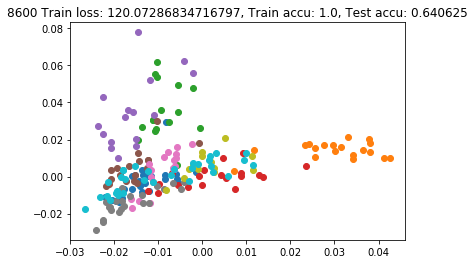

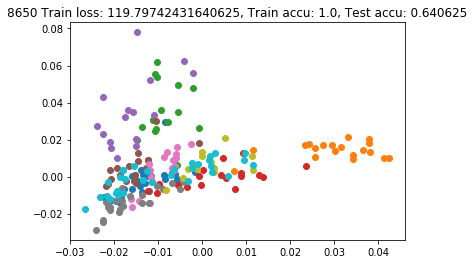

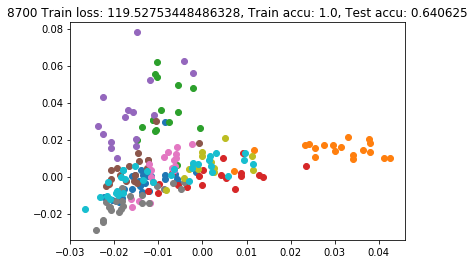

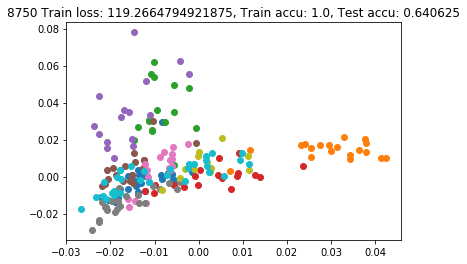

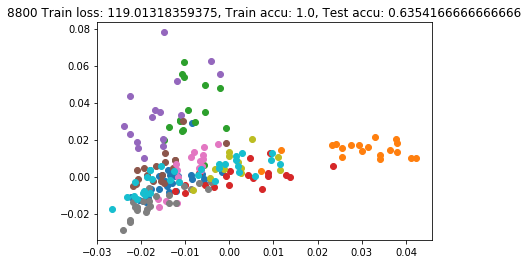

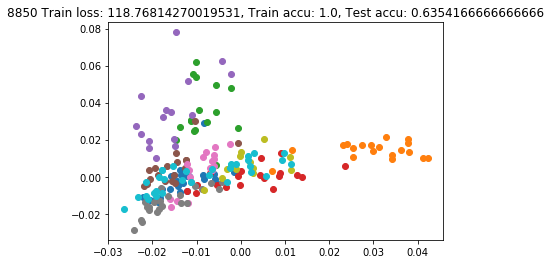

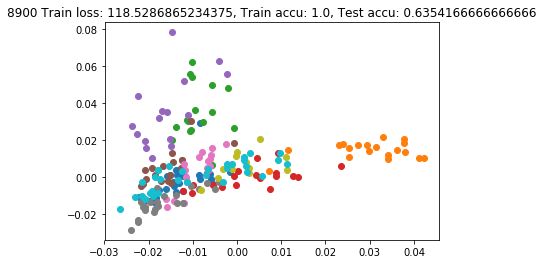

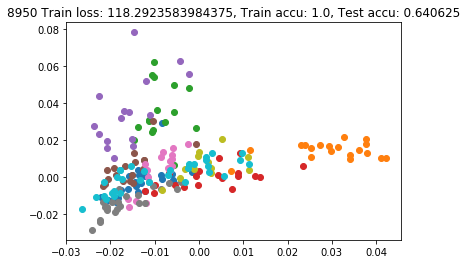

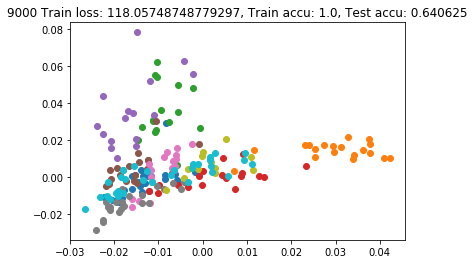

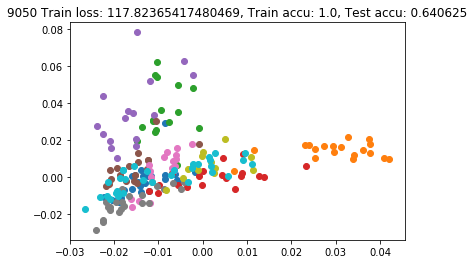

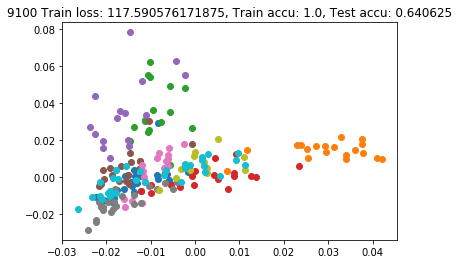

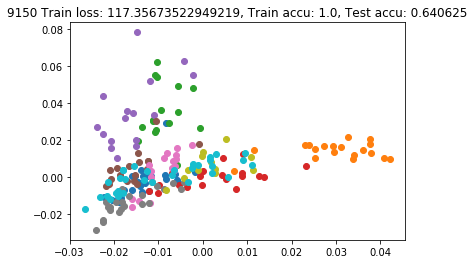

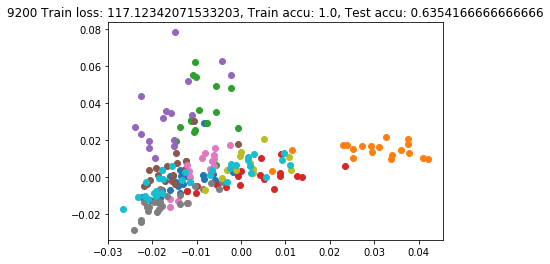

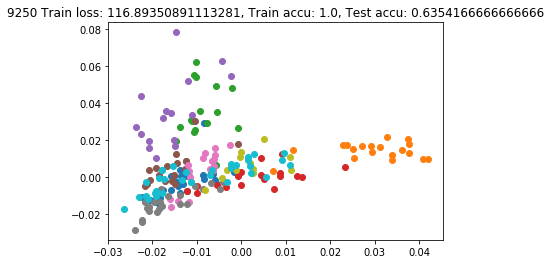

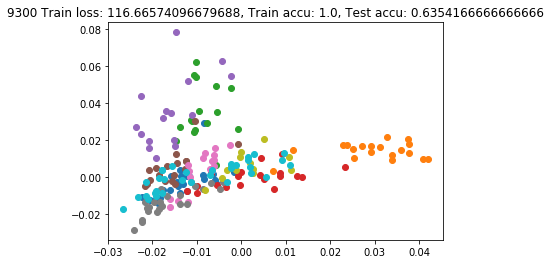

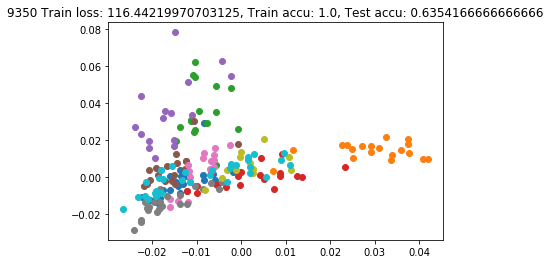

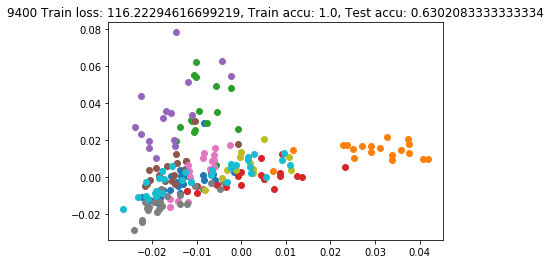

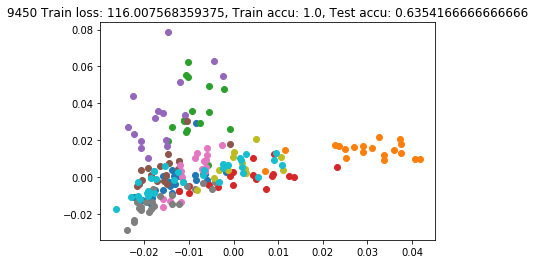

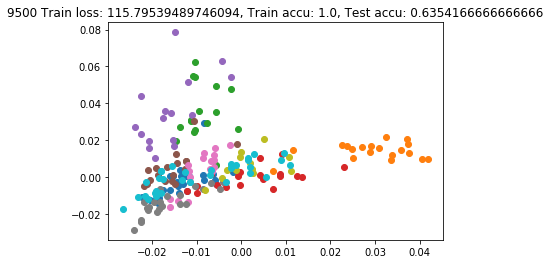

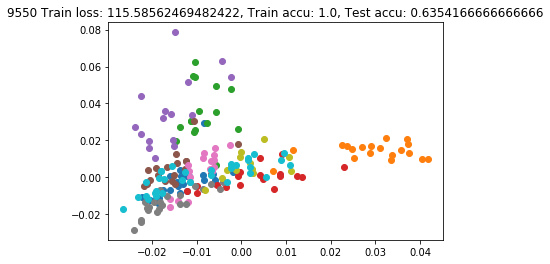

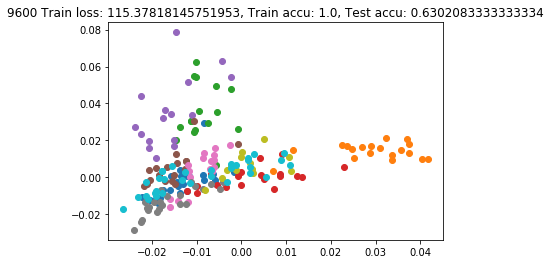

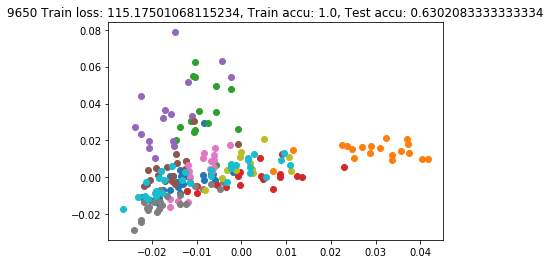

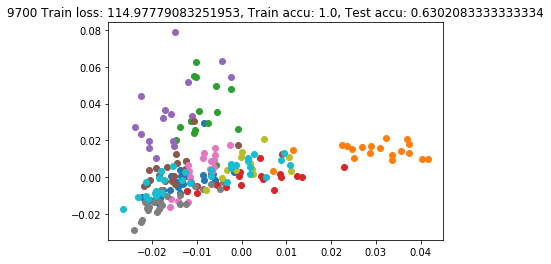

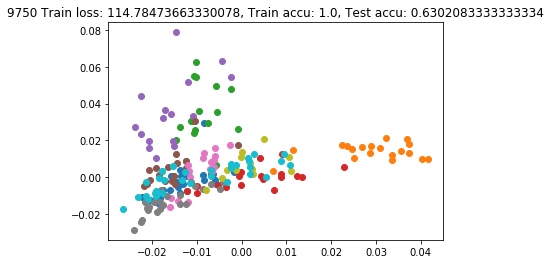

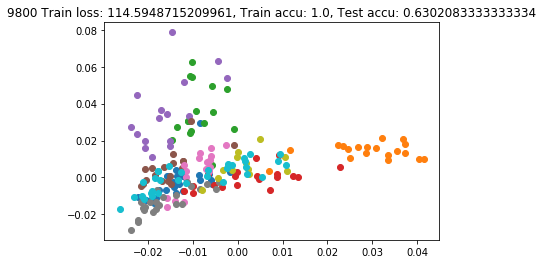

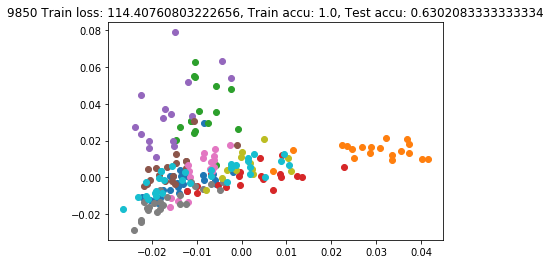

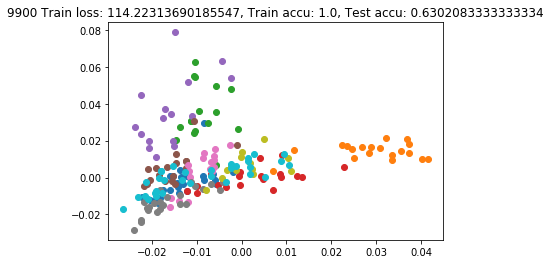

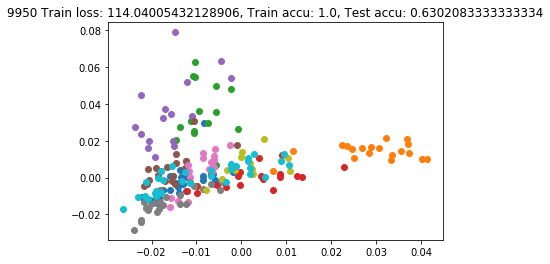

In [20]:
r = dims
A = tf.Variable(np.eye(r, dims) + 0.01* np.ones((r,dims)))
#A = tf.Variable(tf.random.uniform((r,dims)))

#margin = 0.5
#margin = 0.001
margin = .1
mu = 1

#optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
train_losses = []
test_accuracies = []
train_accuracies = []
#plot_func(X @ np.array(tf.nn.softmax(A,axis=0)), y)
with tf.device("/cpu:0"):
    for i in tqdm.tqdm(range(10000)):
        grads = grad(X_train, A, nn, y_train, margin)
        optimizer.apply_gradients(zip([grads], [A]))

        if i % 50 == 0:
            L = np.array(tf.nn.softmax(A,axis=0))
            train_loss = loss(X_train, A, nn, y_train, margin).numpy()
            train_losses.append(train_loss)
            train_accu = compute_knn_accuracy(X_train @ L.T, y_train, X_train @ L.T, y_train)
            test_accu = compute_knn_accuracy(X_train @ L.T, y_train, X_test @ L.T, y_test)
            test_accuracies.append(test_accu)
            train_accuracies.append(train_accu)
            plt.figure()
            plt.title(f"{i} Train loss: {train_loss}, Train accu: {train_accu}, Test accu: {test_accu}")
            
            x_bar = X_train @ L.T
            trans_X_train = pca.transform(x_bar)

            for i in range(num_classes):
                plt.plot(trans_X_train[y_train==i,0], trans_X_train[y_train==i,1] , 'o')
            #plot_func(X @ np.array(tf.nn.softmax(A,axis=0)),y)
            #plt.title(loss(X, A, nn, y, margin).numpy())

            display.clear_output(wait=True)
            display.display(plt.gcf())
        

#optimizer.minimize(loss)

In [23]:
# Save the data
np.savez("amazon_data_result",test_accuracies=test_accuracies, train_accuracies=train_accuracies, train_losses=train_losses )
np.save("A_amazon.npy", A)

## Load the trained A matrix and create distance matrices

In [157]:
A2 = np.load("./A_cat_and_dog.npy")

In [158]:
L = np.array(tf.nn.softmax(A2.item(),axis=0))
print(f"Train_accu: {compute_knn_accuracy(X_train @ L.T, y_train, X_train @ L.T, y_train)}, "+
      f"Test_accu: {compute_knn_accuracy(X_train @ L.T, y_train, X_test @ L.T, y_test)}")

Train_accu: 0.98, Test_accu: 0.6


## Traffic signs distance

In [160]:
idx = np.argsort(y_train)
L = np.array(tf.nn.softmax(A2.item(),axis=0))
trans_dists = pairwise_distances(X_train[idx,:] @ L.T, metric=single_chi_sq_dist)
dists = pairwise_distances(X_train[idx,:], metric=single_chi_sq_dist)

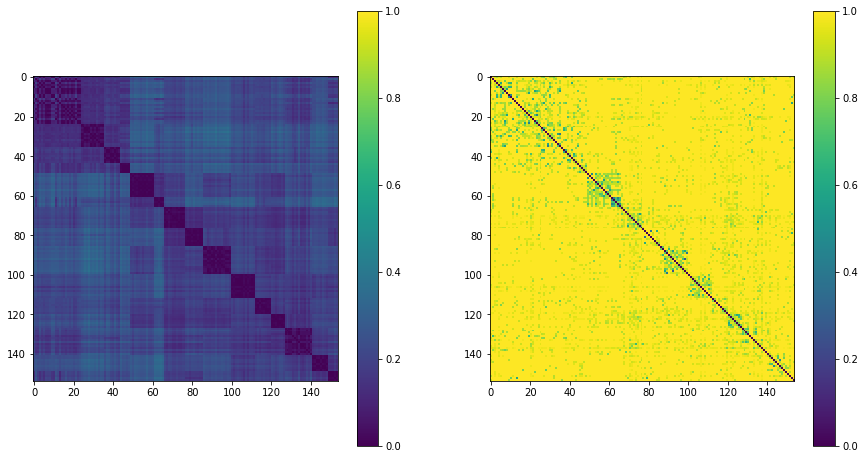

In [70]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(trans_dists, vmin=0, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.imshow(dists, vmin=0, vmax=1)
plt.colorbar()

## Cats and dogs distance

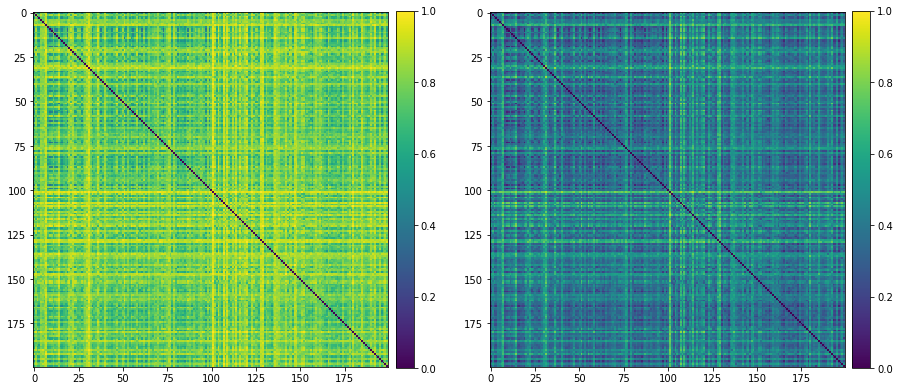

In [161]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
margin = .1
magic_scale = 0.047
plt.figure(figsize=(15,8))
#ax = plt.gca()
ax1 = plt.subplot(121)
plt.imshow(dists, vmin=0, vmax=1)
plt.colorbar(fraction=magic_scale,pad=0.02)
ax2 = plt.subplot(122)
im = plt.imshow(trans_dists, vmin=0, vmax=1)
plt.colorbar(fraction=magic_scale,pad=0.02)
plt.savefig("cats_and_dogs_dist.pdf")



# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.5)
#divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.05)

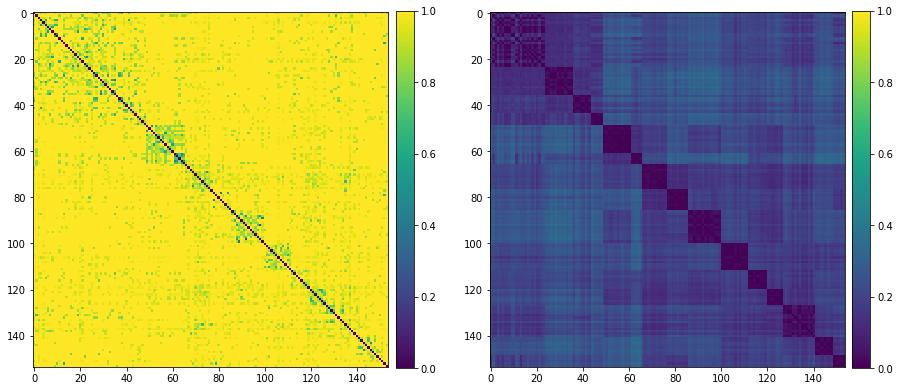

In [153]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
margin = .1
magic_scale = 0.047
plt.figure(figsize=(15,8))
#ax = plt.gca()
ax1 = plt.subplot(121)
plt.imshow(dists, vmin=0, vmax=1)
plt.colorbar(fraction=magic_scale,pad=0.02)
ax2 = plt.subplot(122)
im = plt.imshow(trans_dists, vmin=0, vmax=1)
plt.colorbar(fraction=magic_scale,pad=0.02)
plt.savefig("road_sign_dist.pdf")


# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.5)
#divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.05)